In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [90]:
products = pd.read_csv('/content/drive/My Drive/ML Specialization/amazon_baby_subset.csv')

In [91]:
import re
import string

def remove_punctuation(text):
    pattern = f'[{string.punctuation}]'
    return re.sub(pattern, '', text)

products = products.fillna({'review':''})
products['review_clean'] = products['review'].apply(remove_punctuation)
products = products[products['rating'] != 3]
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

In [92]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [93]:
import json

with open('/content/drive/My Drive/ML Specialization/module-10-assignment-train-idx.json', 'r') as f:
    train_indices = json.load(f)
with open('/content/drive/My Drive/ML Specialization/module-10-assignment-validation-idx.json', 'r') as f:
    valid_indices = json.load(f)
with open('/content/drive/My Drive/ML Specialization/important_words.json', 'r') as f:
    important_words = json.load(f)

train_data = products.iloc[train_indices]
valid_data = products.iloc[valid_indices]

In [94]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    feature_matrix = np.array(dataframe[features])
    label_array = np.array(dataframe[label])
    return feature_matrix, label_array

def predict_probability(feature_matrix, coefficients):
    
    score = np.dot(feature_matrix, coefficients)
    predictions = 1 / (1 + np.exp(-score))
    return predictions

def feature_derivative(errors, feature):     

    derivative = np.dot(errors, feature)
    return derivative
    
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):

    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]   
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)   
    
    return lp

In [96]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(valid_data, important_words, 'sentiment')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [97]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
print("Gradient single data point: %s" % gradient_single_data_point)
print("           --> Should print 0.0")

Gradient single data point: 0.0
           --> Should print 0.0


In [98]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients)
indicator = (sentiment_train[i:i+B]==+1)

errors = indicator - predictions
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])
print("Gradient mini-batch data points: %s" % gradient_mini_batch)
print("                --> Should print 1.0")

Gradient mini-batch data points: 1.0
                --> Should print 1.0


In [99]:
feature_matrix_train.shape

(47780, 194)

In [101]:
from math import sqrt

def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []

    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]

    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        ### YOUR CODE HERE
        predictions = predict_probability(feature_matrix[i:(i+batch_size),:], coefficients)

        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        ### YOUR CODE HERE
        indicator = (sentiment[i:i+batch_size]==+1)

        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            ### YOUR CODE HERE
            derivative = feature_derivative(errors, feature_matrix[i:i+batch_size,j]) 
                  # Compute the product of the step size, the derivative, and
            # the **normalization constant** (1./batch_size)
            ### YOUR CODE HERE
            coefficients[j] += step_size * derivative * 1. / batch_size

        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print('Iteration %*d: Average log likelihood (of data points  [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp))

        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0                

    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

In [103]:
initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = 1
max_iter = 10

coefficients, log_likelihood = logistic_regression_SG(feature_matrix_train, sentiment_train,\
                                        initial_coefficients=np.zeros(194),\
                                        step_size=5e-1, batch_size=1, max_iter=10)

Iteration 0: Average log likelihood (of data points  [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points  [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points  [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points  [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points  [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points  [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points  [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points  [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points  [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points  [00009:00010]) = -0.00000124


In [104]:
initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = len(feature_matrix_train)
max_iter = 200

coefficients_batch, log_likelihood_batch = logistic_regression_SG(feature_matrix_train, sentiment_train,\
                                        initial_coefficients=np.zeros(194),\
                                        step_size=5e-1, batch_size=len(feature_matrix_train), max_iter=200)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

In [105]:
step_size = 1e-1
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration   11: Average log likelihood (of data points  [01100:01

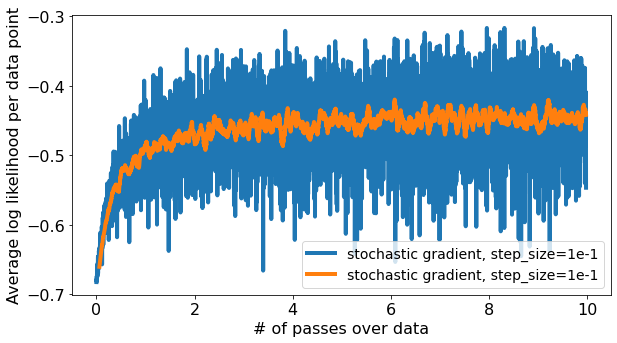

In [107]:
def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')

    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          label='stochastic gradient, step_size=1e-1')

make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic gradient, step_size=1e-1')

In [108]:
step_size = 1e-1
batch_size = 100
num_passes = 200
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration     0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration    11: Average log likelihood (of data point

In [109]:
coefficients_batch, log_likelihood_batch = logistic_regression_SG(feature_matrix_train, sentiment_train,\
                                        initial_coefficients=np.zeros(194),\
                                        step_size=5e-1, batch_size=len(feature_matrix_train), max_iter=200)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

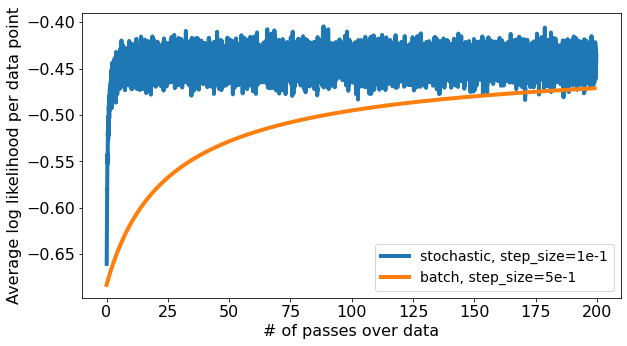

In [110]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic, step_size=1e-1')
make_plot(log_likelihood_batch, len_data=len(feature_matrix_train), batch_size=len(feature_matrix_train),
          smoothing_window=1, label='batch, step_size=5e-1')

In [111]:
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd = {}
log_likelihood_sgd = {}
for step_size in np.logspace(-4, 2, num=7):
    coefficients_sgd[step_size], log_likelihood_sgd[step_size] = logistic_regression_SG(feature_matrix_train, sentiment_train,\
                                       initial_coefficients=np.zeros(194),\
                                       step_size=step_size, batch_size=batch_size, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.69313622
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.69313170
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.69313585
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.69312487
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.69313157
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.69313113
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.69311121
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.69312692
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.69312115
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.69312811
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.69311286
Iteration   11: Average log likelihood (of data points  [01100:01

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp


Iteration  200: Average log likelihood (of data points  [20000:20100]) = -4.03649619
Iteration  300: Average log likelihood (of data points  [30000:30100]) = -11.71871507


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


Iteration  400: Average log likelihood (of data points  [40000:40100]) = -4.11623572
Iteration  500: Average log likelihood (of data points  [02300:02400]) = -4.51804551
Iteration  600: Average log likelihood (of data points  [12300:12400]) = -18.00039632
Iteration  700: Average log likelihood (of data points  [22300:22400]) = -3.21322097
Iteration  800: Average log likelihood (of data points  [32300:32400]) = -4.86259490
Iteration  900: Average log likelihood (of data points  [42300:42400]) = -5.82392573
Iteration 1000: Average log likelihood (of data points  [04600:04700]) = -3.49662959
Iteration 2000: Average log likelihood (of data points  [09200:09300]) = -12.55715941
Iteration 3000: Average log likelihood (of data points  [13800:13900]) = -1.81247271
Iteration 4000: Average log likelihood (of data points  [18400:18500]) = -28.05579428
Iteration 4769: Average log likelihood (of data points  [47600:47700]) = -19.48690022


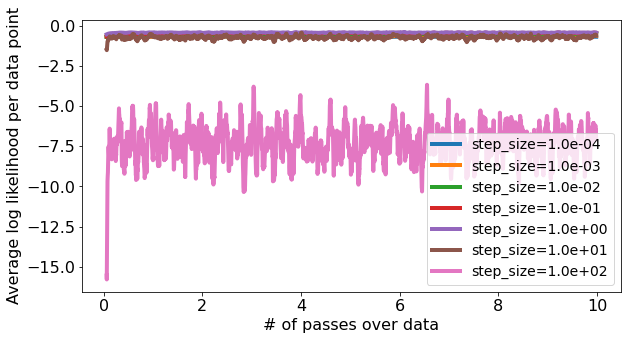

In [112]:
for step_size in np.logspace(-4, 2, num=7):
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)

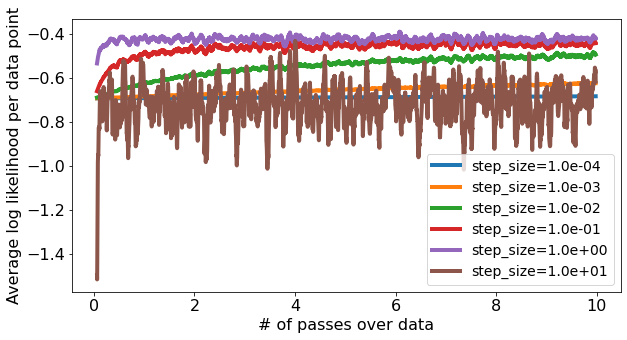

In [113]:
for step_size in np.logspace(-4, 2, num=7)[0:6]:
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)